100%|██████████| 1032/1032 [2:49:27<00:00,  9.85s/it] 


Epoch [0], val_loss: 0.2021, val_acc: 0.9321


100%|██████████| 1032/1032 [2:43:54<00:00,  9.53s/it] 


Epoch [1], val_loss: 0.0908, val_acc: 0.9702


100%|██████████| 1032/1032 [2:41:56<00:00,  9.42s/it] 


Epoch [2], val_loss: 0.0346, val_acc: 0.9896


100%|██████████| 1032/1032 [2:46:26<00:00,  9.68s/it] 


Epoch [3], val_loss: 0.0367, val_acc: 0.9891


100%|██████████| 1032/1032 [2:52:47<00:00, 10.05s/it] 


Epoch [4], val_loss: 0.0272, val_acc: 0.9912


100%|██████████| 1032/1032 [2:54:07<00:00, 10.12s/it] 


Epoch [5], val_loss: 0.0362, val_acc: 0.9871


100%|██████████| 1032/1032 [2:49:05<00:00,  9.83s/it] 


Epoch [6], val_loss: 0.0259, val_acc: 0.9919


100%|██████████| 1032/1032 [2:50:18<00:00,  9.90s/it] 


Epoch [7], val_loss: 0.0324, val_acc: 0.9896


100%|██████████| 1032/1032 [2:46:15<00:00,  9.67s/it] 


Epoch [8], val_loss: 0.0355, val_acc: 0.9892


100%|██████████| 1032/1032 [2:41:59<00:00,  9.42s/it] 


Epoch [9], val_loss: 0.1067, val_acc: 0.9672


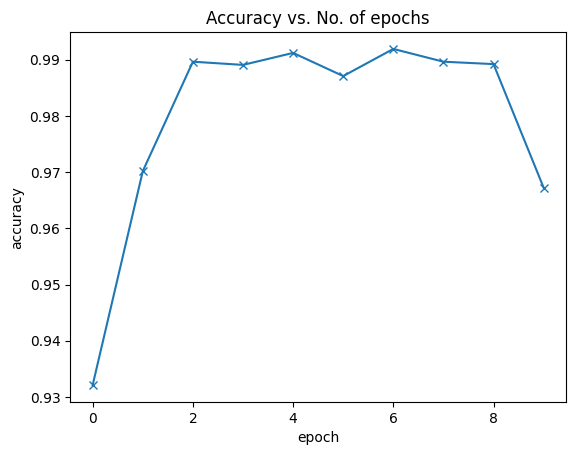

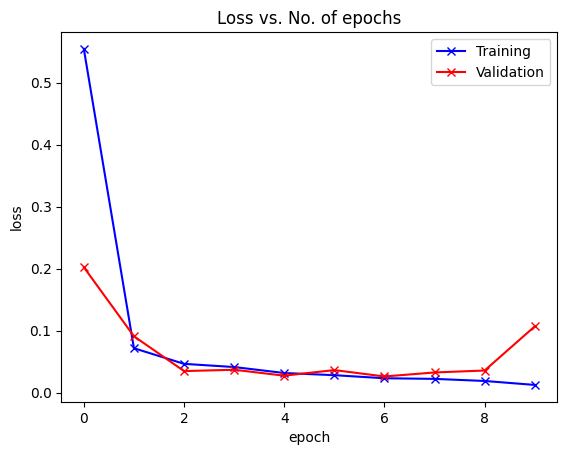

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Custom Image Classification Base Class
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["val_loss"], result["val_acc"]
            )
        )


# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet34 Model
class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes=29):
        super(ResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self.make_layer(ResidualBlock, 64, 3)
        self.layer2 = self.make_layer(ResidualBlock, 128, 4, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 6, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Utility functions
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# Data transforms
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

# Load dataset
dataset = datasets.ImageFolder(
    root="C:/Users/akhip/OneDrive/Desktop/Data 441/asl_alphabet_train/asl_alphabet_train",
    transform=transform,
)

# Split dataset
val_size = 7000
test_size = 14000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_dl = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
)
val_dl = DataLoader(val_ds, batch_size=64, num_workers=4, pin_memory=True)

# Model instance and device transfer
model = to_device(ResNet34(), device)


# Evaluation function
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# Training function
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Training parameters
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

# Model training
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


# Plotting results
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")


def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")
    plt.show()


plot_accuracies(history)
plt.show()
plot_losses(history)
plt.show()

# Saving the ResNet34 model
torch.save(model.state_dict(), "ResNet34.pth")